In [1]:
from stochastic.processes.continuous import FractionalBrownianMotion
from scipy.special import gamma
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import numpy as np
import time


def GenerateNoise(H, t_fin, t_init, N, alpha, rng):
    '''the parameter rng produces unique series of random numbers at each simulation trajectory'''
    fbm = FractionalBrownianMotion(hurst=1-H, t=(t_fin - t_init), rng=rng)
    noise = np.sqrt(2 / gamma(1 + alpha)) * fbm.sample(N)
#     print(f"{noise[1]}\n")
    return noise


def force_term(j, x):
    return x[j-1]


def approxfun(n, alpha, j, x):
    return float(force_term(j,x)*(((n-j+1)**alpha) - ((n-j) ** alpha)))


def simulate_process(args):
    H, t_fin, t_init, N, alpha, A, dt, r, xr, xa, m, w, seed, i = args

    # random number generator with a unique seed
    rng = np.random.default_rng(seed)
    coefficient = (m*(w**2)*(dt**alpha))/(gamma(1+alpha))
    noise = GenerateNoise(H, t_fin, t_init, N, alpha, rng)

    x = np.zeros(N)
    xm = 0
    tr = 0
    reset_step = 1
    count = 0
    nn = []

    for n in range(1, N):
        r1 = rng.uniform(0, 1)
        if r1 < r * dt:
            x[n] = xr
            xm = xr
            reset_time = n*dt
            reset_step = n
            noise = GenerateNoise(H, t_fin, t_init+reset_time, N-reset_step, alpha, rng)
            count += 1
        else:
            x[n] = xm + x[0] + (-coefficient*sum(approxfun(n, alpha, j, x) for j in range(reset_step, n+1)) + noise[n-reset_step])/A

        # stop simulation if the particle hits the absorbing boundary at x = xa
        if x[n] >= xa:
            
            return n*dt
            break

    return n*dt 

if __name__ == "__main__":
    rs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]      # reset rates 
    xr = 0          # reset position 
    m = 1.0         # mass 
    w = 1.0         # barrier frequency 
    zeta = 1.0      # friction coefficient 
    H = 0.95        # Hurst index
    N = 100000      # simulation steps
    ntrajs = 100000  # number of simulations/trajectories 
    xa = 1          # absorbing boundary 
    t_init = 0.0    # initial time 
    t_fin = 100.0   # final time 
    dt = (t_fin - t_init) / N   # time interval 
    print(f'Time interval = {dt} sec.') 
    alpha = 2-2*H 
    A = 2*zeta*H*(2*H-1)*gamma(1-alpha) 
    # t1 = time.time() 
    mfpt = []; var = []; cov = []; sim_time = []

    
    for r in rs:
        t1 = time.time() 
        with mp.Pool(processes=56) as pool: 
            # generate unique seeds for each trajectory 
            base_seed = int(time.time()) 
            seeds = [base_seed + i for i in range(ntrajs)] 
            args = [(H, t_fin, t_init, N, alpha, A, dt, r, xr, xa, m, w, seeds[i], i) for i in range(ntrajs)] 
            fpt = pool.map(simulate_process, args) 
            # print(np.mean(fpt))
            
            mfpt.append(np.mean(fpt))
            var.append(np.var(fpt))
            cov.append(np.var(fpt)/np.mean(fpt))

            time_req = (time.time() - t1)/60 
            sim_time.append(time_req)
            
            print(f'r = {r}, MFPT = {np.round(np.mean(fpt),5)}, Variance = {np.round(np.var(fpt),5)}, COV = {np.round(np.var(fpt)/np.mean(fpt),5)}, simulation time = {time_req} min.') 

    outputs = {"reset rate": rs, "mfpt": mfpt, "variance": var, "cov": cov, "sim. time": sim_time}
    df = pd.DataFrame(outputs)
    df.to_csv(f"./fpt_properties/fpt_H{H}.csv", index=False)

Time interval = 0.001 sec.
r = 0, MFPT = 0.56456, Variance = 12.39736, COV = 21.95916, simulation time = 111.04019836584727 min.
r = 1, MFPT = 0.19874, Variance = 0.15983, COV = 0.80426, simulation time = 3.838923716545105 min.
r = 2, MFPT = 0.15998, Variance = 0.07815, COV = 0.48848, simulation time = 5.033602460225423 min.
r = 3, MFPT = 0.14005, Variance = 0.04996, COV = 0.35676, simulation time = 5.739235631624857 min.
r = 4, MFPT = 0.12708, Variance = 0.03718, COV = 0.29258, simulation time = 6.250055086612702 min.
r = 5, MFPT = 0.11761, Variance = 0.02896, COV = 0.24624, simulation time = 6.318716053167979 min.
r = 6, MFPT = 0.11106, Variance = 0.02422, COV = 0.21813, simulation time = 6.897634279727936 min.
r = 7, MFPT = 0.10557, Variance = 0.0208, COV = 0.19706, simulation time = 7.5214358488718664 min.
r = 8, MFPT = 0.10144, Variance = 0.01863, COV = 0.18362, simulation time = 7.979458697636923 min.
r = 9, MFPT = 0.0977, Variance = 0.01672, COV = 0.17117, simulation time = 8.34

In [2]:
df.to_csv(f"./fpt_properties/fpt_H{H}.csv", index=False)

In [2]:
df

,reset rate,mfpt,variance,cov,sim. time
0,0,0.564564,12.397355,21.959163,111.040198
1,1,0.198736,0.159834,0.804255,3.838924
2,2,0.159982,0.078149,0.488485,5.033602
3,3,0.140046,0.049963,0.356763,5.739236
4,4,0.127082,0.037182,0.292581,6.250055
5,5,0.117608,0.028960,0.246240,6.318716
6,6,0.111058,0.024225,0.218128,6.897634
7,7,0.105571,0.020804,0.197060,7.521436
8,8,0.101443,0.018627,0.183621,7.979459
9,9,0.097696,0.016723,0.171172,8.348265


In [80]:
np.mean(fpt)

1.8660104999999994

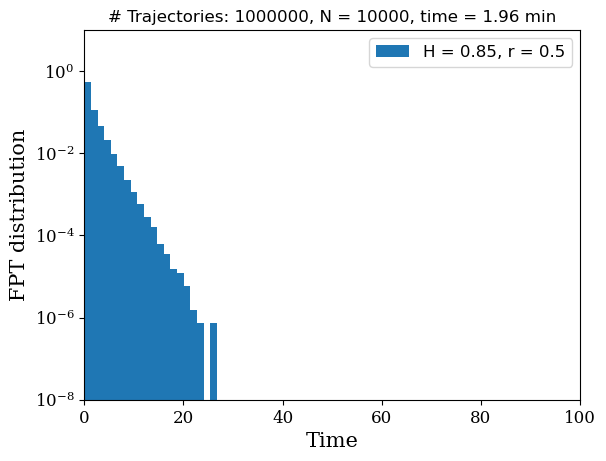

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


plt.hist(fpt, bins=20, density=True, label=f'H = {H}, r = {r}', align='mid')
plt.xlim(0,t_fin)
plt.ylim(1e-8,10)
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('Time', fontsize=15, fontfamily='serif')
plt.ylabel('FPT distribution', fontsize=15, fontfamily='serif')
plt.title(f'# Trajectories: {nreps}, N = {N}, time = {np.round(time_req,2)} min')
plt.xticks(fontsize=12,fontfamily='serif')
plt.yticks(fontsize=12,fontfamily='serif')
plt.savefig(f"/home/debasish/Documents/resetting_fpt/results/at_different_H/17-01-2026/fpt_N{N}_trajs{nreps}_xr{xr}_r{r}_H{H}.png")
plt.show()

In [6]:
df = pd.DataFrame(fpt)
df.to_csv(f"/home/debasish/Documents/resetting_fpt/results/at_different_H/17-01-2026/fpt_N{N}_trajs{nreps}_xr{xr}_r{r}_H{H}.csv")

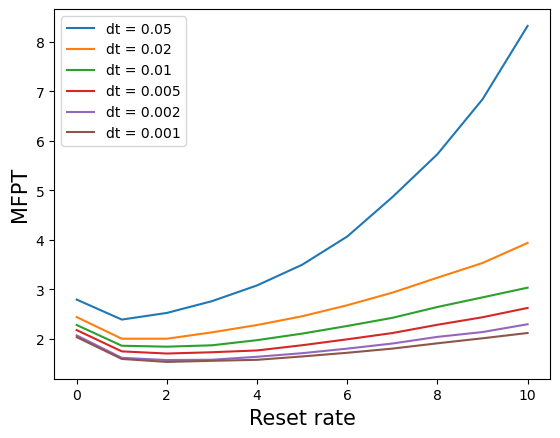

In [24]:
plt.plot(rs, mfpt_0p05, label = "dt = 0.05")
plt.plot(rs, mfpt_0p02, label = "dt = 0.02")
plt.plot(rs, mfpt_0p01, label = "dt = 0.01")
plt.plot(rs, mfpt_0p005, label = "dt = 0.005")
plt.plot(rs, mfpt_0p002, label = "dt = 0.002")
plt.plot(rs, mfpt_0p001, label = "dt = 0.001")
plt.xlabel("Reset rate", fontsize=15)
plt.ylabel("MFPT", fontsize=15)
plt.legend()